In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

### Look at one pT value

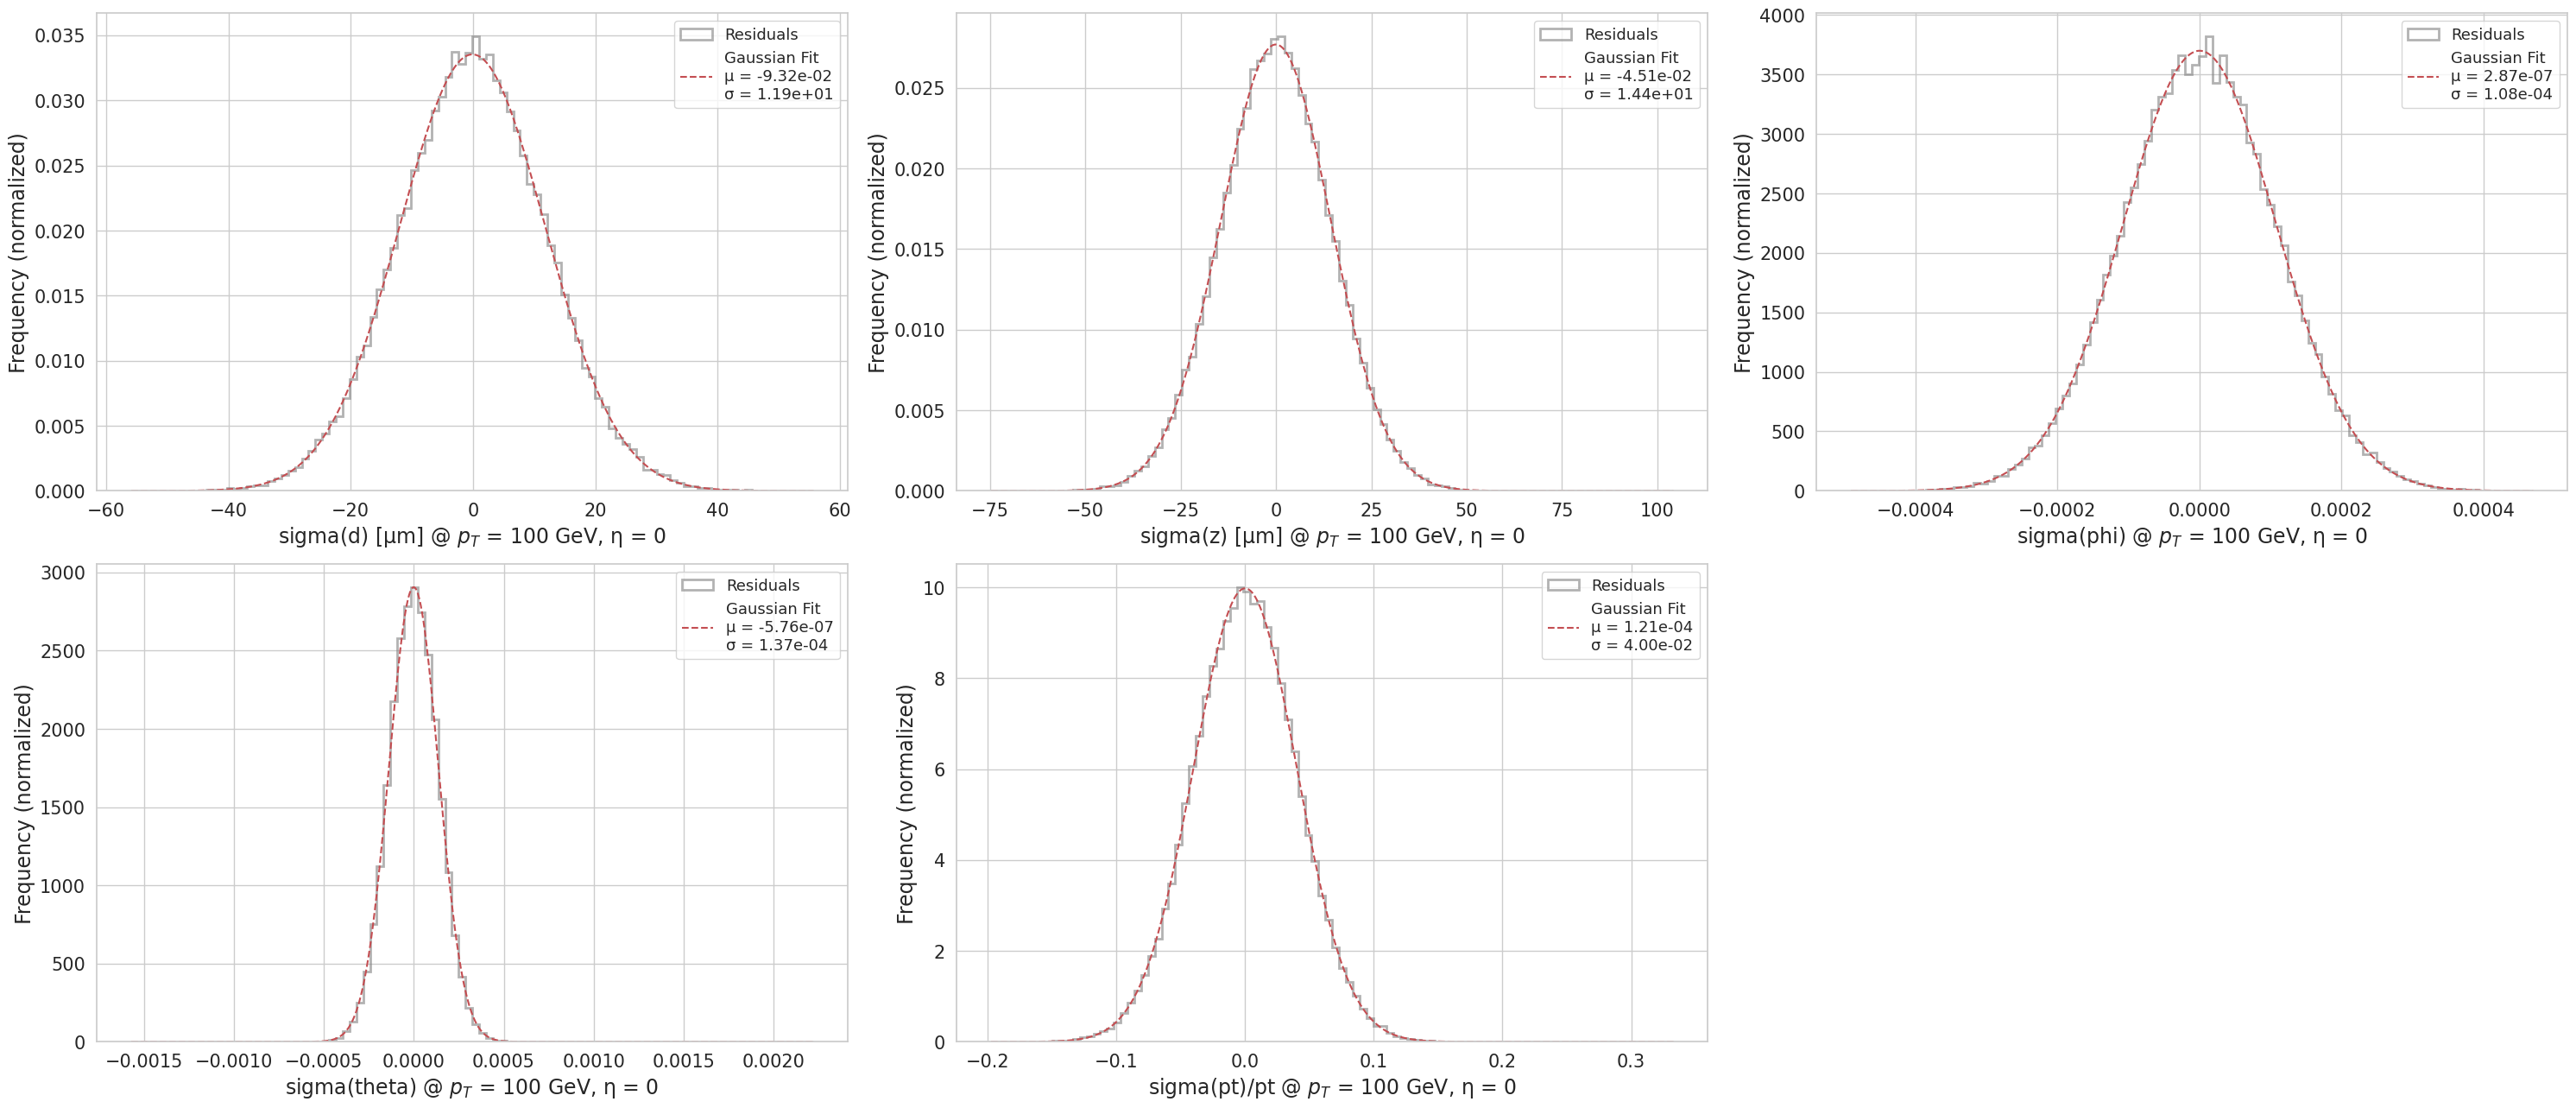

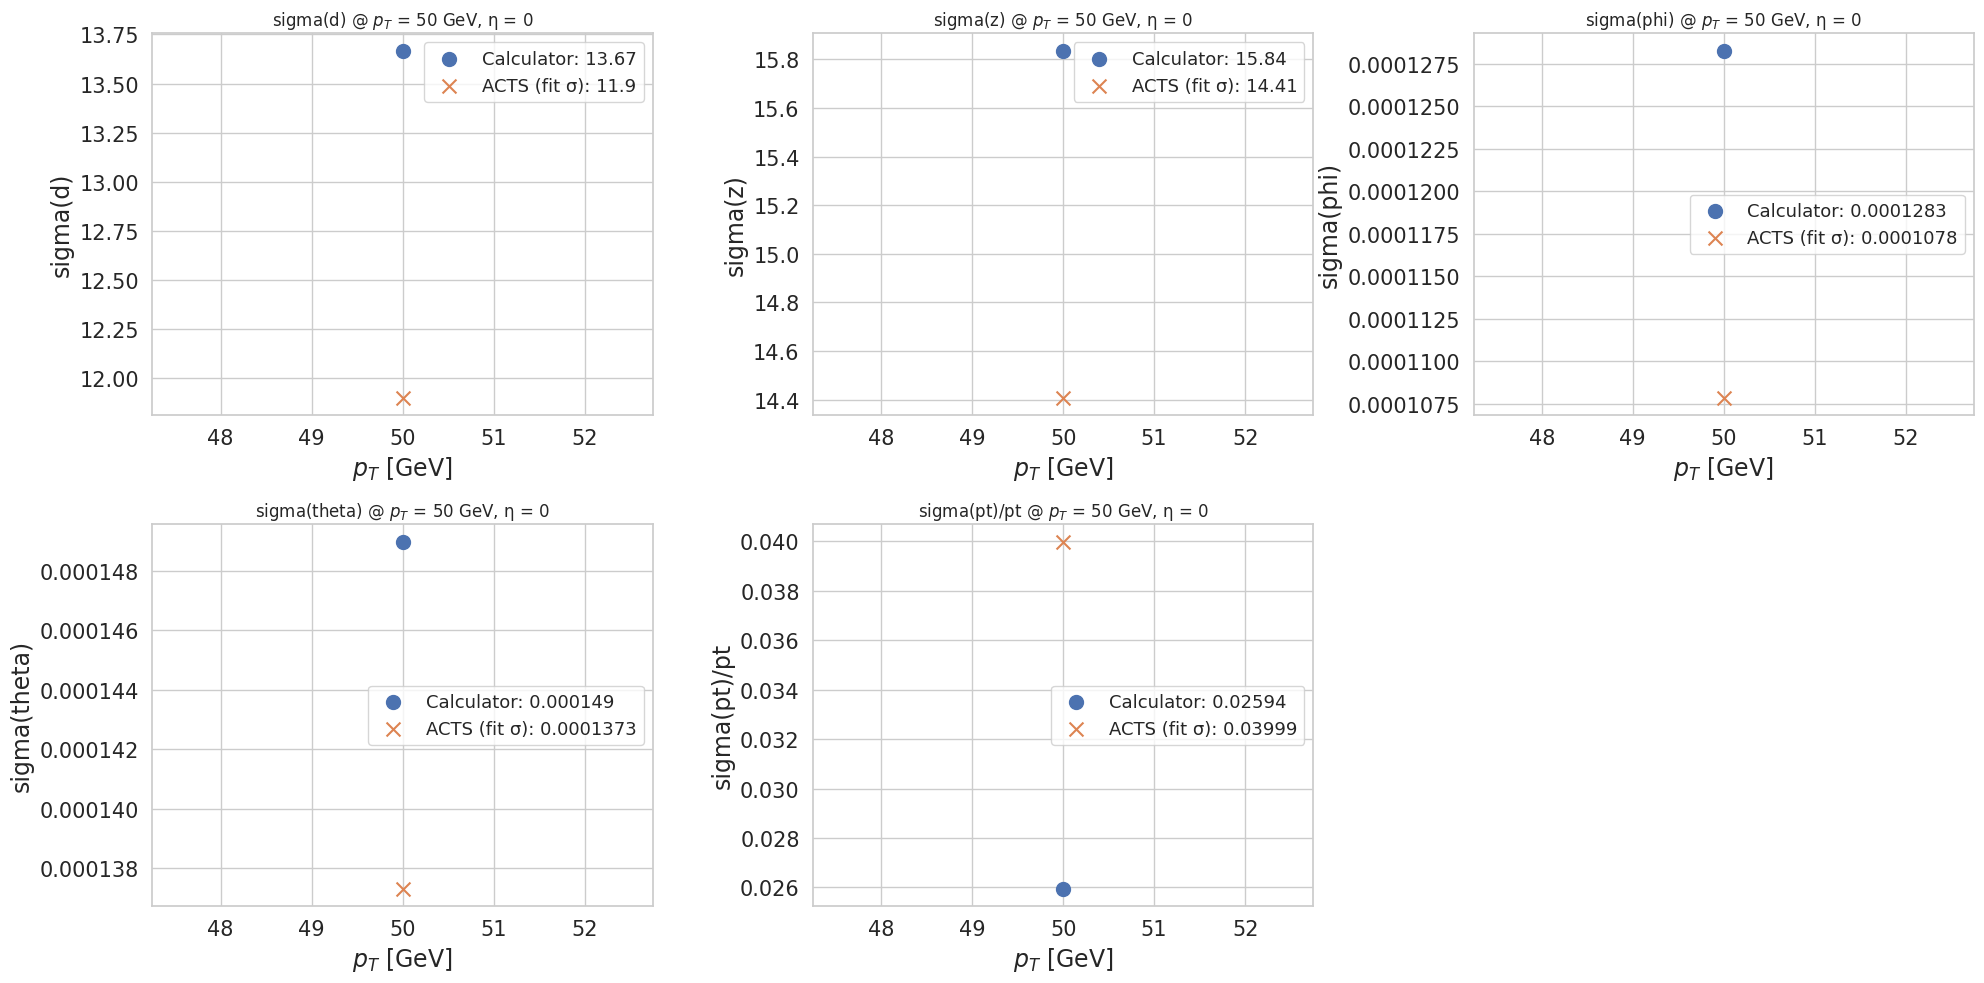

In [6]:
path = '/data/jlai/iris-hep/OutputPT/'
# pT_values = [1, 3, 5, 10]
pT_values = np.arange(10, 100+10, 10)
i = -1
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit",# "res_ePT_fit", "res_ePTrel_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_truth - pT_reco)/pT_reco),
}

'''
fit_results = {}
plt.figure(figsize=(30, 13))
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(f"{title_labels} @ $p_T$ = {p} GeV, η = {eta}")
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
'''
p, eta = pT_values[i], 0
B, m = 2, 0.106
fit_results = {}

# Decide the order explicitly so plots are stable
keys_order = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(30, 13))

for i, key in enumerate(keys_order):
    data = ak.to_numpy(labels[key])
    data = data[~np.isnan(data)]

    if data.size == 0:
        fit_results[key] = np.nan
        continue

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

    plt.subplot(2, 3, i + 1)
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2,
                               density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma),
             'r--', label=f'Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.xlabel(f"{title_labels[i]} @ $p_T$ = {p} GeV, η = {eta}")
    # plt.xlabel(key)
    plt.ylabel("Frequency (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Saving ACTS results

In [14]:
path = '/data/jlai/iris-hep/OutputPT/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

pT_values = np.concatenate((np.linspace(1, 15, 15), np.linspace(20, 100, 9)))
# pT_values = np.arange(10, 100+10, 10)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth)/pT_truth)
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with pT = 1 GeV
Saving ACTS track resol with pT = 2 GeV
Saving ACTS track resol with pT = 3 GeV
Saving ACTS track resol with pT = 4 GeV
Saving ACTS track resol with pT = 5 GeV
Saving ACTS track resol with pT = 6 GeV
Saving ACTS track resol with pT = 7 GeV
Saving ACTS track resol with pT = 8 GeV
Saving ACTS track resol with pT = 9 GeV
Saving ACTS track resol with pT = 10 GeV
Saving ACTS track resol with pT = 11 GeV
Saving ACTS track resol with pT = 12 GeV
Saving ACTS track resol with pT = 13 GeV
Saving ACTS track resol with pT = 14 GeV
Saving ACTS track resol with pT = 15 GeV
Saving ACTS track resol with pT = 20 GeV
Saving ACTS track resol with pT = 30 GeV
Saving ACTS track resol with pT = 40 GeV
Saving ACTS track resol with pT = 50 GeV
Saving ACTS track resol with pT = 60 GeV
Saving ACTS track resol with pT = 70 GeV


/tmp/ipykernel_2433428/4197850839.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30, 13))


Saving ACTS track resol with pT = 80 GeV
Saving ACTS track resol with pT = 90 GeV
Saving ACTS track resol with pT = 100 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

### Comparison between ACTS and Tracking Resolution Calculator

In [15]:
def D(pT_value, eta_value):    
    MEAS_PATH = f"/data/jlai/iris-hep/OutputPT/output_pt_{pT_value}/measurements.root"
    MAT_PATH  = "/data/jlai/iris-hep/material_composition.root"

    PIXEL   = {16, 17, 18}   # 17 barrel, 16/18 endcaps
    SSTRIP  = {23, 24, 25}
    LSTRIP  = {28, 29, 30}

    def vol_to_tech(vid: int) -> str:
        if vid in PIXEL:  return "pixel"
        if vid in SSTRIP: return "sstrip"
        if vid in LSTRIP: return "lstrip"
        return "pixel"  # fallback

    # ---------- per-layer medians from measurements ----------
    cols = ["volume_id","layer_id","true_x","true_y","true_z","var_loc0","var_loc1","residual_loc0","residual_loc1"]
    fmt = {c: (lambda x: f"{x:.6e}") for c in ["x_over_X0","res_loc0_std_m","sigma_loc1_for_add","R_m"]}
    with uproot.open(MEAS_PATH) as f:
        a = f["measurements"].arrays(cols, library="pd")

    a["R_m"]           = np.sqrt(a.true_x**2 + a.true_y**2) * 1e-3
    a["sigma_loc0_m"]  = np.sqrt(a.var_loc0.clip(lower=0)) * 1e-3
    a["sigma_loc1_m"]  = np.sqrt(a.var_loc1.clip(lower=0)) * 1e-3

    def _std_meters(s):
        return np.nanstd(s, ddof=0) * 1e-3

    df_layers = (
        a.groupby(["volume_id","layer_id"], as_index=False)
        .agg(R_m=("R_m","median"),
            # sigma_loc0_m=("sigma_loc0_m","median"),
            # sigma_loc1_m=("sigma_loc1_m","median"))
            res_loc0_std_m=("residual_loc0", _std_meters),
            res_loc1_std_m=("residual_loc1", _std_meters))
        .sort_values(["volume_id","layer_id"])
        .reset_index(drop=True)
    )

    # ---------- x/X0 per technology at η≈eta_value ----------
    def vals_edges_any(h):
        """
        Return (vals, edges) for TH1* or TProfile from uproot.
        vals: bin contents (for TProfile: mean Y per bin)
        edges: x-axis bin edges
        """
        # 1) try the easy path (TH1 with to_numpy)
        try:
            vals, edges = h.to_numpy()
            return np.asarray(vals), np.asarray(edges)
        except Exception:
            pass

        # 2) try uproot v5 axis API
        edges = None
        for getter in ("axis", "axis0", "axis", "axis(0)"):
            try:
                # some builds expose axis() or axis(0)
                ax = h.axis() if getter=="axis" else h.axis(0)
                edges = np.asarray(ax.edges())
                break
            except Exception:
                continue

        # 3) last resort: uniform fallback (only if we must)
        vals = np.asarray(h.values())
        if edges is None:
            edges = np.linspace(-5, 5, len(vals)+1)
        return vals, edges

    def x0_at_eta_interp_generic(h, eta):
        vals, edges = vals_edges_any(h)
        centers = 0.5*(edges[:-1] + edges[1:])
        eta_c = np.clip(eta, centers.min(), centers.max())
        return float(np.interp(eta_c, centers, vals))

    # ---- usage ----
    with uproot.open(MAT_PATH) as mf:
        def pick_interp(key, eta):
            v = x0_at_eta_interp_generic(mf[key], eta)
            # DEBUG: show neighbors used for interpolation
            vals, edges = vals_edges_any(mf[key])
            centers = 0.5*(edges[:-1] + edges[1:])
            i = np.searchsorted(centers, eta, side='left')
            i0 = max(i-1, 0); i1 = min(i, len(centers)-1)
            # print(f"{key}: interp at η={eta:+.3f} using "
            #     f"[η0={centers[i0]:+.3f}, val0={vals[i0]:.6g}] and "
            #     f"[η1={centers[i1]:+.3f}, val1={vals[i1]:.6g}] -> {v:.6g}")
            return v

        x0_beam  = pick_interp("beampipe_x0_vs_eta_all", eta_value)
        x0_pixel = pick_interp("pixel_x0_vs_eta_all",     eta_value)
        x0_sstr  = pick_interp("sstrips_x0_vs_eta_all",   eta_value)
        x0_lstr  = pick_interp("lstrips_x0_vs_eta_all",   eta_value)


    def x0_for_tech(tech: str) -> float:
        return {"pixel": x0_pixel, "sstrip": x0_sstr, "lstrip": x0_lstr}.get(tech, x0_pixel)

    df_layers["tech"]       = df_layers["volume_id"].map(vol_to_tech)
        
    x0_map = {
        "pixel":  x0_pixel,
        "sstrip": x0_sstr,
        "lstrip": x0_lstr,
    }
    df_layers["x0_total_by_tech"] = df_layers["tech"].map(x0_map)

    n_layers_by_tech = df_layers.groupby("tech").size().to_dict() # count layers per tech

    # Per-layer share: total / count
    df_layers["x_over_X0"] = df_layers.apply(
        lambda r: r["x0_total_by_tech"] / max(n_layers_by_tech.get(r["tech"], 1), 1),
        axis=1,
    )

    # df_layers["x_over_X0"]  = df_layers["tech"].map(x0_for_tech)

    df_layers["sigma_loc1_for_add"] = df_layers["res_loc1_std_m"].fillna(9999.0) # fill NaN with 9999

    # ---------- build Detector ----------
    mydetector = Detector()

    mydetector.addlayer(x0_beam, 9999.0, 9999.0, 0.024)

    for _, row in df_layers.sort_values("R_m").iterrows():
        if row['tech'] != 'lstrip':
            mydetector.addlayer(
                float(row["x_over_X0"]),
                float(row["res_loc0_std_m"]),
                float(row["sigma_loc1_for_add"]),  # <- NaNs become 9999 here
                float(row["R_m"]),
            )

    # ---------- print (optional) ----------
    out = df_layers.copy()
    out["sigma_loc1_m"] = out["res_loc1_std_m"].fillna(9999.0)
    # print("Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):")
    # print(out[["volume_id","layer_id","tech","x_over_X0","res_loc0_std_m","sigma_loc1_for_add","R_m"]]
    #       .to_string(index=False, formatters=fmt))
    return mydetector


# < -- Tracking Error Calculator -- >
def cal2():
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2.0, 0.105658
        mydetector = D(p, eta)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc_result = cal2()
'''
# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(pT_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(pT_values, y_calc_result[var_label], 'o--', label=f"My result")

    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    # plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom

plt.tight_layout()
plt.show()
'''


/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlai/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlai

'\n# < -- plot the var vs. pT -- >\nplt.figure(figsize=(20, 10))\nfor var_label in var_labels:\n    idx = var_labels.index(var_label)\n    plt.subplot(231 + idx)\n\n    # plt.plot(pT_values, y_calc_default[var_label], \'o--\', label=f"Default Calculator in zenodo")\n    plt.plot(pT_values, y_calc_result[var_label], \'o--\', label=f"My result")\n\n    # plt.plot(pT_values, y_acts[var_label], \'x--\', label=f"ACTS (fit σ)")\n    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt=\'x--\', capsize=2, label="ACTS Fit σ ± Δσ")\n    plt.xlabel(r"$p_T$ [GeV]")\n    plt.ylabel(var_label)\n    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")\n    plt.yscale(\'log\')\n    plt.legend()\n    plt.grid(True)\n    # plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom\n\nplt.tight_layout()\nplt.show()\n'

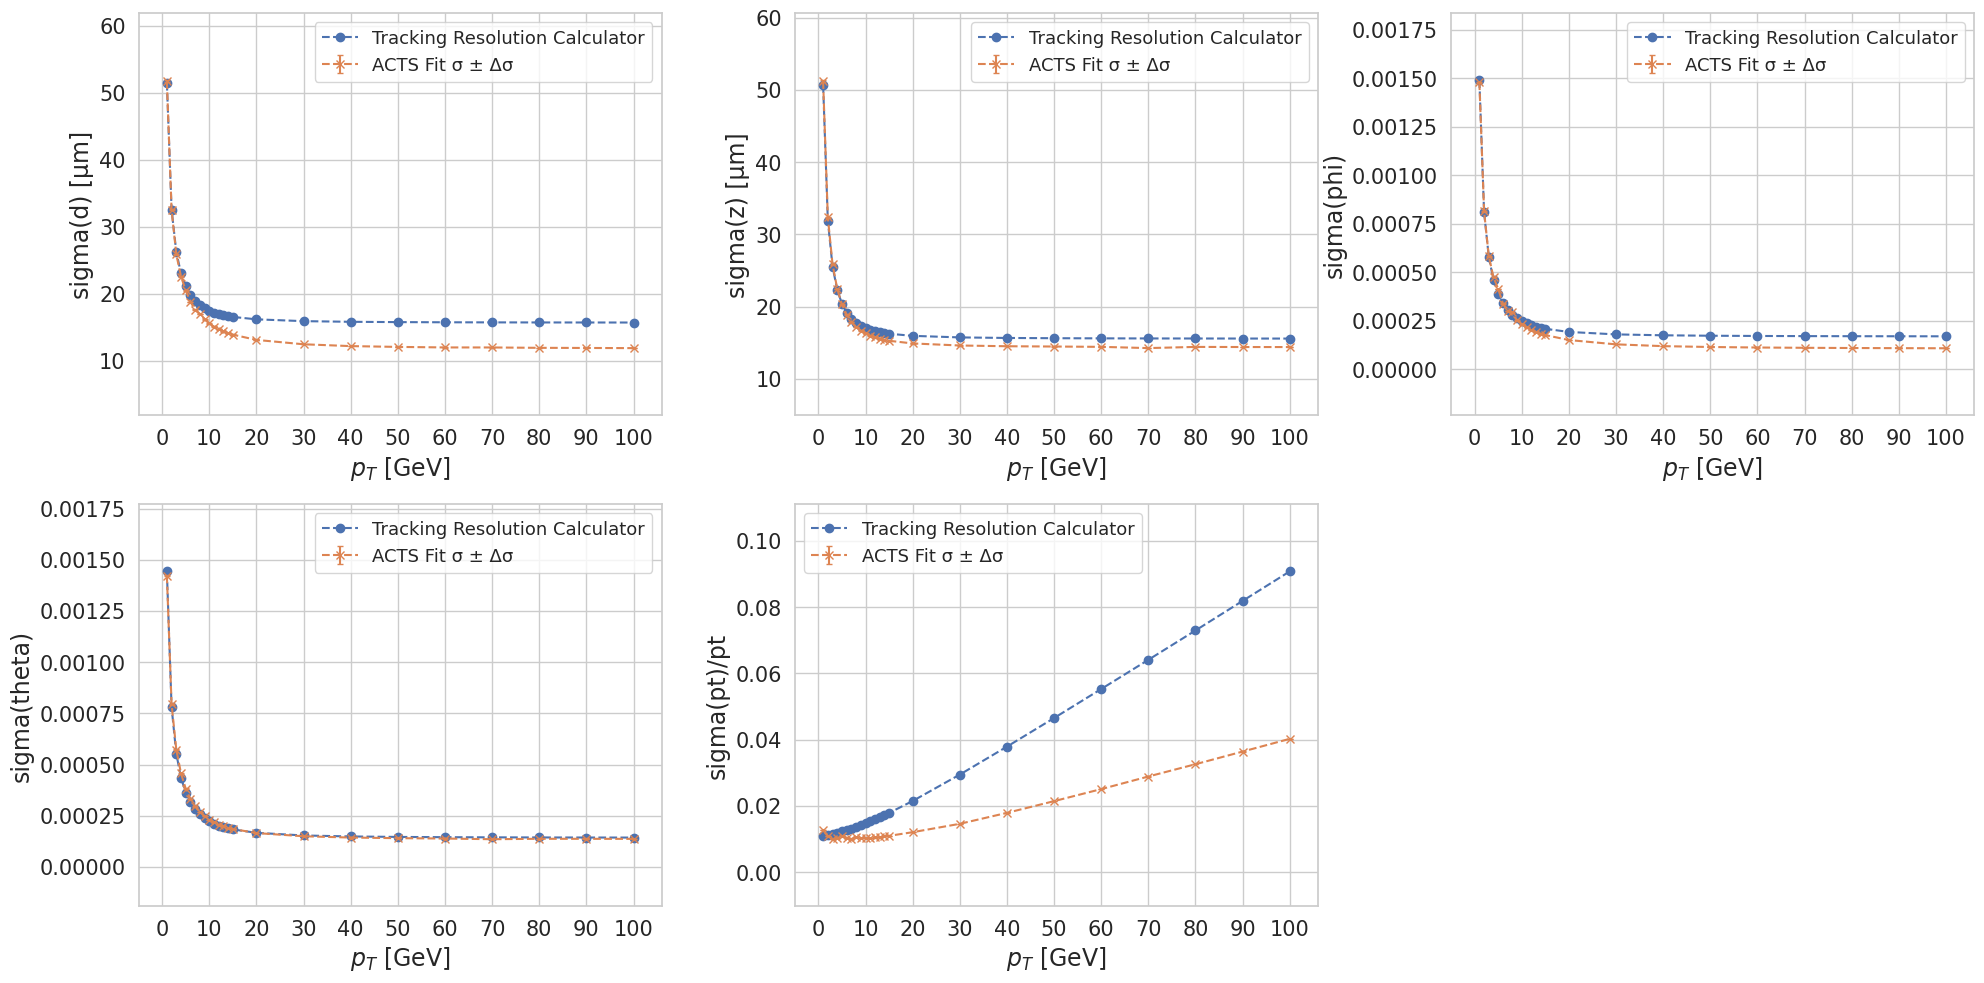

In [21]:
# < -- plot the var vs. pT -- >
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(20, 10))
for i in range(len(var_labels)):
    var_label = var_labels[i]
    title_label = title_labels[i]
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(pT_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(pT_values, y_calc_result[var_label], 'o--', label=f"Tracking Resolution Calculator")

    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(title_label)
    # plt.yticks(np.arange(0, 70, 10))
    plt.xticks(np.arange(0, 110, 10))
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)
    plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom

plt.tight_layout()
plt.show()

tmp1:  [51.48041773 32.57277476 26.2600806  23.03836381 21.09964022 19.82700944
 18.9478084  18.31412356 17.84355742 17.48765198 17.21013798 16.99217657
 16.81758625 16.6749964  16.55746224 16.19743671 15.9264706  15.8293292
 15.78268093 15.75773672 15.74211084 15.73201411 15.726319   15.72062787]
tmp2:  [51.717255 32.52214  25.884384 22.584846 20.518354 18.802418 17.632835
 17.016018 16.17706  15.576811 15.105767 14.747365 14.413896 14.144768
 13.910596 13.125802 12.476292 12.202064 12.082832 12.003697 11.999425
 11.944993 11.926087 11.899887]
tmp1:  [50.63298048 31.87309938 25.54167573 22.30490431 20.39028321 19.16799163
 18.34332543 17.76609917 17.34756365 17.0352379  16.79715941 16.61159679
 16.46495172 16.34586927 16.24921077 15.95680859 15.74181095 15.66567672
 15.63077704 15.60984287 15.59754319 15.59010717 15.58455429 15.58077798]
tmp2:  [51.17143  32.36066  25.850697 22.45042  20.30899  18.884855 17.887049
 17.197687 16.691715 16.294426 15.99052  15.752364 15.56443  15.407905


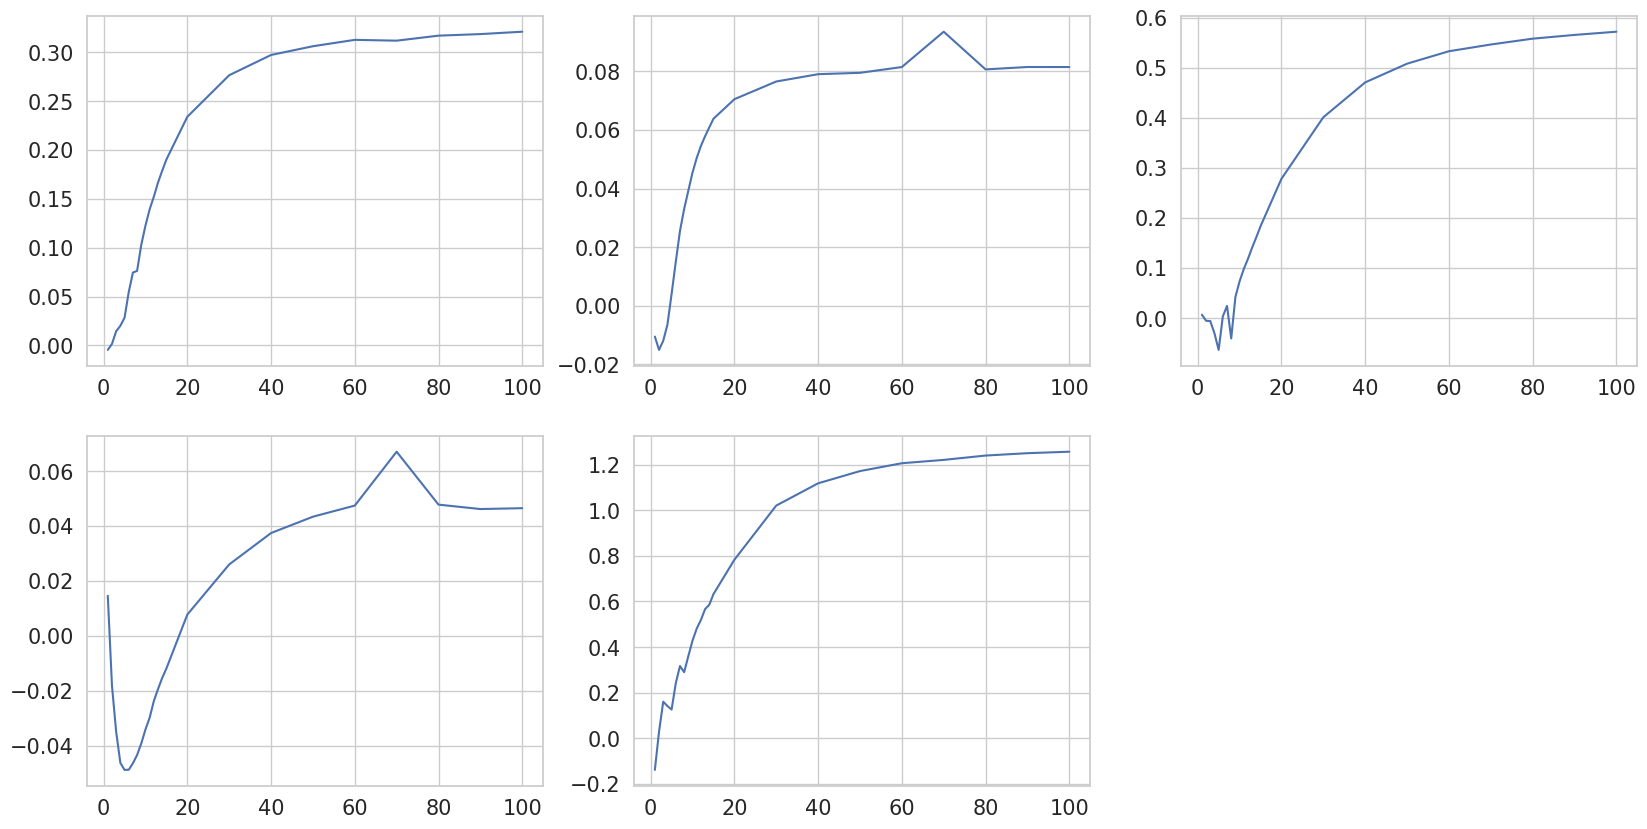

In [26]:
plt.figure(figsize=(20, 10))
for i in range(len(var_labels)):
    var_label = var_labels[i]
    title_label = title_labels[i]
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(pT_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    # plt.plot(pT_values, y_calc_result[var_label], 'o--', label=f"Tracking Resolution Calculator")
    # plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    tmp1 = np.array(y_calc_result[var_label])
    tmp2 = np.array(y_acts[var_label])
    print("tmp1: ", tmp1)
    print("tmp2: ", tmp2)
    plt.plot(pT_values, (tmp1 - tmp2)/tmp2)
